<a href="https://colab.research.google.com/github/maugsan/QnA-ngrams/blob/main/Presentaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Question Answering System 


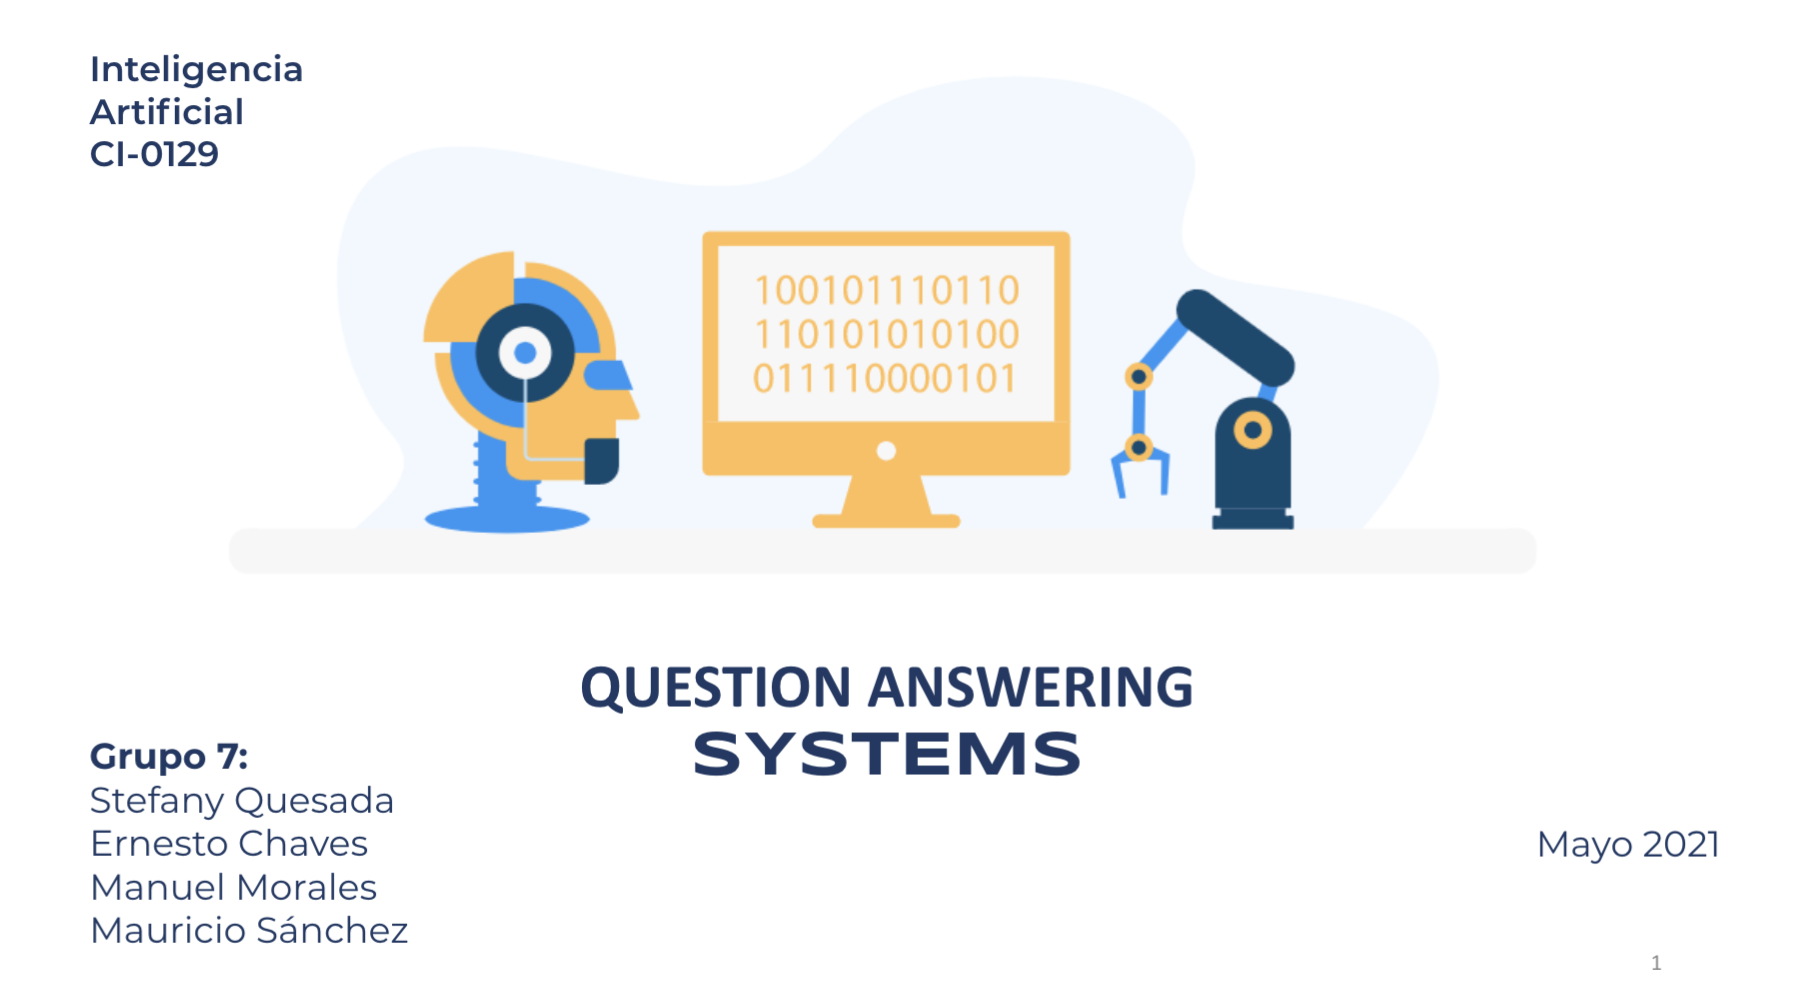

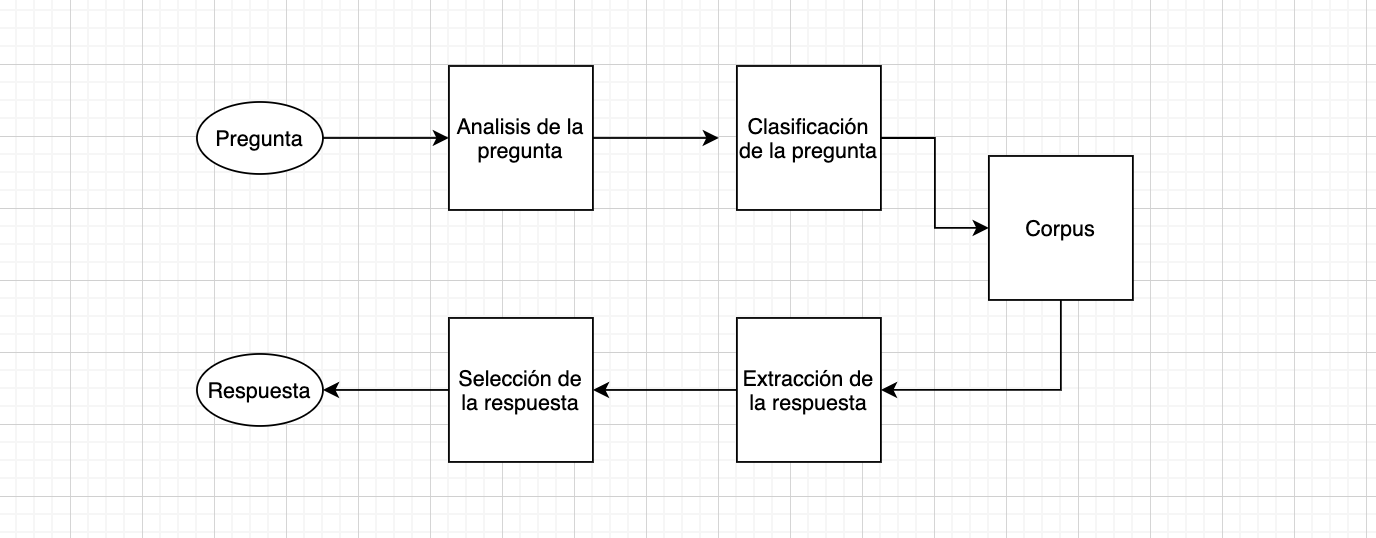

## **ENTRADA** : {Pregunta}

In [581]:
import pickle
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

# Note: each question needs	interpunct(.)
nltk.data.clear_cache()
question = """

Mamá ama a papá.
Mi papá me mima.
Papá ama a mamá.
Mi papá me ama.

"""
parts = nltk.sent_tokenize(question)

questions = []
for part in parts:
  temp = part.strip().replace(".","")
  questions.append(temp) 
  print(temp)

with open('questions.p', "wb") as f:
    pickle.dump(questions, f)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Mamá ama a papá
Mi papá me mima
Papá ama a mamá
Mi papá me ama


## 1. Análisis de la pregunta

### Clasificación de la pregunta




In [592]:
def classify_question(question):
    q = question.lower().split()
    if q[0] == 'donde':
        return 'lugar'
    elif 'año'  in question:
            return 'fecha'
    elif 'hora'  in question:
            return 'tiempo'
    elif 'pais' in question:
        return 'pais'
    elif q[0] == 'quien':
        return 'persona'
    elif q[0] == 'que':
        return 'definición'
    else:
      return 'ninguna'


question = []
with (open("questions.p", "rb")) as openfile:
    while True:
        try:
            question.append(pickle.load(openfile))
        except EOFError:
            break

classify_question(question[0][0])

'ninguna'

### Reformulación de la pregunta

## 2. Extracción de la *infomación* IE

In [591]:

import nltk.data
import pickle
nltk.data.clear_cache()
#corpus = nltk.data.load('chapter01.txt', format='text')
#corpus  = nltk.data.load('book_ES_1_2.txt', format='text')
#corpus = "Fuzzy Wuzzy was a bear. Fuzzy Wuzzy had no hair. Fuzzy Wuzzy wasn’t fuzzy, was he?"
corpus = """

Esa es la mesa.
La masa está en la mesa.
Papá amasa en la mesa.
La mesa.
Mi papá me mima.
Mi mamá me ama.
Papá ama a mamá.


"""

# Save corpus
with open('corpus.p', "wb") as f:
    pickle.dump(corpus, f)

print(corpus)





Esa es la mesa.
La masa está en la mesa.
Papá amasa en la mesa.
La mesa.
Mi papá me mima.
Mi mamá me ama.
Papá ama a mamá.





In [593]:
import re
from nltk.tokenize import sent_tokenize
nltk.data.clear_cache()

corpus = []
with (open("corpus.p", "rb")) as openfile:
    while True:
        try:
            corpus.append(pickle.load(openfile))
        except EOFError:
            break


# Split the text in array of sentences
sentences = nltk.sent_tokenize(corpus[0])

# Replace special characters
#sentence_list = [re.sub(r"[^a-zA-Z ]", " ", temp) for temp in sentences]


# Print sentences filtered
new_corpus = ""
for s in sentences:
  new_corpus += "<s> "+ s.replace('\n', '').replace('.', '')  + "<s> "
  # print(" <s> "+ s.replace('\n', '').replace('.', '') + " </s> " )

with open('sentences.p', "wb") as f:
    pickle.dump(new_corpus, f)
    while True:
      try:
         print("Saved")
         break;
      except EOFError:
          break




Saved


## 3. Selección de respuestas


In [594]:
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
from nltk.tokenize import WhitespaceTokenizer

corpus = []
with (open("corpus.p", "rb")) as openfile:
    while True:
        try:
            corpus.append(pickle.load(openfile))
        except EOFError:
            break
tk = WhitespaceTokenizer()

tokens = tk.tokenize(corpus[0].lower() )
unigrams = ngrams(tokens, 1)

size = Counter(tokens)

print(size)
with open('unigram_count.p', "wb") as f:
    pickle.dump(size, f)



Counter({'la': 5, 'mesa.': 4, 'papá': 3, 'en': 2, 'mi': 2, 'me': 2, 'esa': 1, 'es': 1, 'masa': 1, 'está': 1, 'amasa': 1, 'mima.': 1, 'mamá': 1, 'ama.': 1, 'ama': 1, 'a': 1, 'mamá.': 1})


In [598]:
from collections import Counter
from nltk import ngrams
from tabulate import tabulate
import pandas

#get corpus
corpus = []
with (open("corpus.p", "rb")) as openfile:
    while True:
        try:
            corpus.append(pickle.load(openfile))
        except EOFError:
            break
            
x = re.sub(r"[^a-zA-Z ]", " ", corpus[0])

bigrm = nltk.bigrams(corpus[0].replace(".","").lower().split())

c = Counter(bigrm)

result = pandas.DataFrame(c.most_common(),
                columns=['Bigram', 'Frequency'])
print(result)
result.to_csv('model.csv',index=False)
    

    

           Bigram  Frequency
0      (la, mesa)          4
1      (mesa, la)          2
2        (en, la)          2
3       (esa, es)          1
4        (es, la)          1
5      (la, masa)          1
6    (masa, está)          1
7      (está, en)          1
8    (mesa, papá)          1
9   (papá, amasa)          1
10    (amasa, en)          1
11     (mesa, mi)          1
12     (mi, papá)          1
13     (papá, me)          1
14     (me, mima)          1
15     (mima, mi)          1
16     (mi, mamá)          1
17     (mamá, me)          1
18      (me, ama)          1
19    (ama, papá)          1
20    (papá, ama)          1
21       (ama, a)          1
22      (a, mamá)          1


## 4. Análisis de las *respuestas*

In [596]:
"""--------------------------
 Libraries 
--------------------------"""
#!pip install nltk
import math
from nltk.util import ngrams
from nltk import *
from collections import Counter
import pandas


def likehood_estimate(sentence, bigrams, unigrams, debug=False, smoothing=False, ):
  """
  MLE 
  :sentence:
  :debug: boolean print some variables dumps
  :smoothing: boolean add laplace smoothing
  """
  V = len(unigrams)

  prob_list = []
  prob_list.append(sentence)
  for current in nltk.bigrams(sentence.lower().split()):

    bigram_p = get_value(bigrams, str(current))
    if(bigram_p):
      bigram_p = bigram_p["Frequency"]
    else:
       bigram_p = 0
    uni, unii = current  
    unigram_p = get_value(unigrams, uni) 
    if (smoothing_laplace):
        
        prob = ( bigram_p + 1 ) / (unigram_p + V)
        print(current , ':', bigram_p, "+ 1 /",unigram_p,  '+ V = ', prob)
    else:
      prob = bigram_p/unigram_p
    
      print(current , ':', bigram_p, "/",unigram_p, ' = ', prob)
    
    prob_list.append(prob)
     
    if (debug):
      print(sentence)
      print(bigram_p)
      print(V)
      print(unigram_p)

  return prob_list

def get_value(d, search_key):
    match = 0
    d = iter(d.items())
    try:
        match = next(val for key, val in d if search_key in key)
        return match
    except:
        pass
    return match


"""--------------------------
 Main
--------------------------"""

questions = []
display_logs = False
smoothing_laplace = True
"""--------------------------
  Load resources
--------------------------"""
#load questions
with (open("questions.p", "rb")) as openfile:
    while True:
        try:
            questions.append(pickle.load(openfile))
        except EOFError:
            break

#load bigrams model 
model = 'model.csv'
bigrams = pandas.read_csv(model, index_col=0, skiprows=0).T.to_dict()

#load unigrams
unigrams = []
with (open("unigram_count.p", "rb")) as openfile:
  while True:
      try:
          unigrams.append(pickle.load(openfile))
      except EOFError:
          break


# iterate each question questions[0]
answers = []
for question in questions[0]:
  mle = likehood_estimate(question, bigrams, unigrams[0], display_logs, smoothing_laplace)
  answers.append(mle)
  print("\n")


with open('answers.p', "wb") as f:
    pickle.dump(answers, f)

('mamá', 'ama') : 0 + 1 / 1 + V =  0.05555555555555555
('ama', 'a') : 1 + 1 / 1 + V =  0.1111111111111111
('a', 'papá') : 0 + 1 / 1 + V =  0.05555555555555555


('mi', 'papá') : 1 + 1 / 2 + V =  0.10526315789473684
('papá', 'me') : 1 + 1 / 3 + V =  0.1
('me', 'mima') : 1 + 1 / 4 + V =  0.09523809523809523


('papá', 'ama') : 1 + 1 / 3 + V =  0.1
('ama', 'a') : 1 + 1 / 1 + V =  0.1111111111111111
('a', 'mamá') : 1 + 1 / 1 + V =  0.1111111111111111


('mi', 'papá') : 1 + 1 / 2 + V =  0.10526315789473684
('papá', 'me') : 1 + 1 / 3 + V =  0.1
('me', 'ama') : 1 + 1 / 4 + V =  0.09523809523809523




## **SALIDA**: Respuesta

In [597]:
!pip install colorama
import math
import decimal
from colorama import Fore, Back, Style
from collections import OrderedDict
answers = []
best_answer = dict()
selected_answer = ()
od = OrderedDict()
def prob(e):
  return e[1]


with (open("answers.p", "rb")) as openfile:
    while True:
        try:
            answers.append(pickle.load(openfile))
        except EOFError:
            break

summative = 0
for anwser in answers[0]:

  for x in range(1, len(anwser) ): 
        summative += math.log(anwser[x]) 
  best_answer.update( {anwser[0]: summative})
  print(anwser[0] ,' ', summative)
  summative = 0

print("\n")


for best in sorted(best_answer.items(), key=prob):
  print(Fore.GREEN,"------------------------------------")
  print(Fore.GREEN,best[0])
  print(Fore.GREEN,"------------------------------------")

  break

print(Fore.WHITE + '')



print(Style.DIM + '')
print(Style.RESET_ALL)



Mamá ama a papá   -7.977968093128549
Mi papá me mima   -6.905252148764019
Papá ama a mamá   -6.697034247666485
Mi papá me ama   -6.905252148764019


 ------------------------------------
 Mamá ama a papá
 ------------------------------------





Referencias:
